In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
tf.config.get_visible_devices('GPU')

2.9.2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DATASET_SIZE = 60000
BATCH_SIZE = 128
EPOCH = 1

In [4]:
def preprocess(x, y):
    x = 2 * tf.cast(x, dtype=tf.float32) / 255. - 1.
    y = tf.cast(y, dtype=tf.int32)
    return x, y

def load():
    (train_data, train_label), (test_data, test_label) = tf.keras.datasets.mnist.load_data()
    train_db = tf.data.Dataset.from_tensor_slices((train_data, train_label))
    train_db = train_db.map(preprocess).repeat().shuffle(DATASET_SIZE).batch(batch_size=BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_db = tf.data.Dataset.from_tensor_slices((test_data, test_label))
    test_db = test_db.map(preprocess).batch(batch_size=BATCH_SIZE)
    return train_db, test_db
(train_db, test_db) = load()
cnt = 0
for batch in test_db:
    if cnt >= 10:
        break
    image = batch[0][0].numpy()
    label = batch[1][0].numpy()
    print(image.shape)
    # plt.imshow(image)
    # plt.title('index: ' + str(cnt) + ' | label: ' + str(label))
    # plt.show()
    cnt = cnt + 1

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


2023-07-21 12:23:48.698869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 12:23:48.699232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-21 12:23:48.770884: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
network = tf.keras.Sequential()
network.add(tf.keras.layers.Conv2D(32,3,input_shape=[28,28,1],padding='same'))#[28,28,32]
network.add(tf.keras.layers.BatchNormalization())
network.add(tf.keras.layers.ReLU())
network.add(tf.keras.layers.MaxPooling2D())#[14,14,64]
network.add(tf.keras.layers.Conv2D(64,3,padding='same'))#[14,14,64]
network.add(tf.keras.layers.BatchNormalization())
network.add(tf.keras.layers.ReLU())
network.add(tf.keras.layers.MaxPooling2D())#[7,7,127]
network.add(tf.keras.layers.Conv2D(128,3,padding='same'))#[7,7,128]
network.add(tf.keras.layers.BatchNormalization())
network.add(tf.keras.layers.ReLU())
network.add(tf.keras.layers.GlobalAveragePooling2D())
network.add(tf.keras.layers.Dense(64))
network.add(tf.keras.layers.BatchNormalization())
network.add(tf.keras.layers.ReLU())
network.add(tf.keras.layers.Dense(10,activation='softmax'))
network.build(input_shape=[None, 28, 28, 1])
network.summary()
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
network.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [6]:
history = network.fit(train_db, epochs=EPOCH, steps_per_epoch=DATASET_SIZE // BATCH_SIZE, validation_data=test_db)

2023-07-21 12:23:49.442541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


467/468 [============================>.] - ETA: 0s - loss: 0.1783 - sparse_categorical_accuracy: 0.9596

2023-07-21 12:23:59.694977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 11s 21ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.9597 - val_loss: 1.1747 - val_sparse_categorical_accuracy: 0.7057


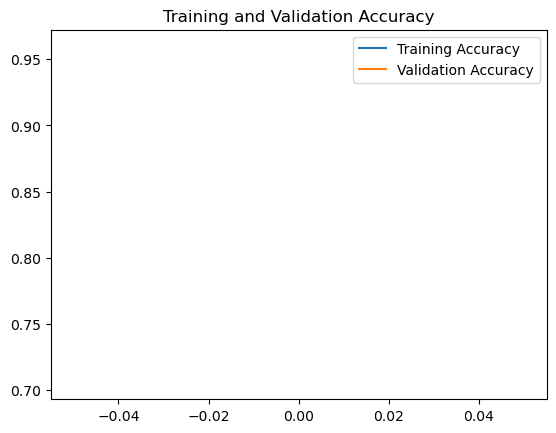

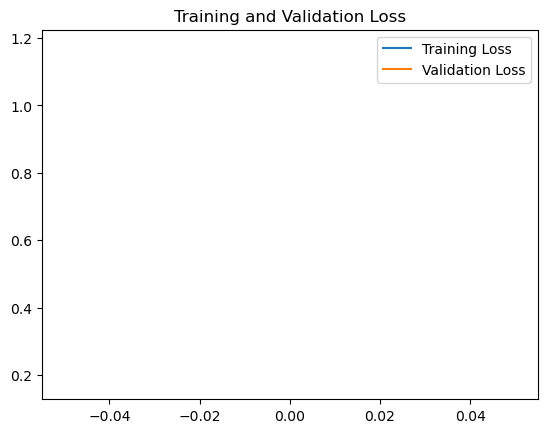

In [7]:
history_acc = history.history['sparse_categorical_accuracy']
history_val_acc = history.history['val_sparse_categorical_accuracy']
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

plt.figure()
plt.plot(history_acc, label='Training Accuracy')
plt.plot(history_val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(history_loss, label='Training Loss')
plt.plot(history_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [8]:
network.evaluate(test_db, batch_size=BATCH_SIZE)

79/79 [==============================] - 1s 9ms/step - loss: 1.1747 - sparse_categorical_accuracy: 0.7057


[1.1746760606765747, 0.7056999802589417]

In [9]:

network.save(r'./CNN.h5')

In [10]:
import numpy as np
pred_y = network.predict(test_db)
result = np.argmax(pred_y, axis=1)
print(result)

23/79 [=======>......................] - ETA: 0s

2023-07-21 12:24:01.637000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 6ms/step
[7 2 1 ... 4 5 6]
